In [1]:
import json
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import keras_tuner as kt
import category_encoders
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy import stats

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True) 

In [2]:
def remove_columns_with_a_single_value(original_dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Removes all columns that only contain one possible value and therefore do not provide any useful information for the neural network.

    Columns with a single unique do not provide any information for the neural network, since every possible sample will have the same value. 

    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to check for columns with single unique values.

    Returns: 
        pd.DataFrame: A modified version of the input DataFrame.
        Note: All columns with a single unique value are dropped.
    """
    return original_dataframe[[column for column in original_dataframe.columns if len(original_dataframe[column].unique()) > 1]]

def remove_low_appearance_values(original_dataframe: pd.DataFrame, count_threshold: int, column_name: str) -> pd.DataFrame:
    """
    Calculates how often each unique values appears in a specific column of the {original_dataframe}.
    
    Rows in the {original_dataframe} with unique values appearing below the {count_threshold} will get removed from the DataFrame. 

    Args:   
        original_dataframe (pd.DataFrame): The input dataframe to be modified.
        count_threshold (int): All unique values with a value_count below this number will be removed.
        column_name (str): The name of the column in the DataFrame on which the value_count for each unique value is calculated.

    Return:
        pd.DataFrame: A modified version of the input DataFrame with all classifications below the defined threshold removed.
    """
    appearance_count = original_dataframe[column_name].value_counts()
    return original_dataframe[~original_dataframe[column_name].isin(appearance_count[appearance_count < count_threshold].index.tolist())]

def remove_high_appearance_values(original_dataframe: pd.DataFrame, count_threshold: int, column_name: str) -> pd.DataFrame:
    """
    Calculates how often each unique values appears in a specific column of the {original_dataframe}.
    
    Rows in the {original_dataframe} with unique values appearing more than the {count_threshold} will get removed from the DataFrame as they can be considered as outliers. 

    Args:   
        original_dataframe (pd.DataFrame): The input dataframe to be modified.
        count_threshold (int): All unique values with a value_count higher than this number will be removed.
        column_name (str): The name of the column in the DataFrame on which the value_count for each unique value is calculated.

    Return:
        pd.DataFrame: A modified version of the input DataFrame with all unique values appearing more often than the defined threshold in {column_name} removed.
    """
    appearance_count = original_dataframe[column_name].value_counts()
    return original_dataframe[~original_dataframe[column_name].isin(appearance_count[appearance_count > count_threshold].index.tolist())]

def number_of_unique_values_per_column(dataframe: pd.DataFrame) -> list[(str, int)]:
    """ 
    Returns a list of tuples containing column names and the amount of unique values in this column.

    Args:  
        original_dataframe (pd.DataFrame): The input DataFrame to determine the number of unique values per column.

    Returns:
        list[(str, int)]: A list of tuples where each tuple contains:
            - The column name as a string.
            - The amount of unique values in that column as an integer.
    """
    return [(column, dataframe[column].nunique()) for column in dataframe.columns]

def replace_null_values_with_column_mode(original_dataframe: pd.DataFrame) -> pd.DataFrame:
    """ 
    Returns the DataFrame without any null value. 
    Each null value gets substituted with the mode value of the column.
    The mode is the value that appears with the highest frequency in the column.
    The null values get substituted, because a neural network needs non-null integer values as input features. 

    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to modify.

    Returns:
        pd.DataFrame: A modified version of the input DataFrame without null values.
    """
    original_dataframe = original_dataframe.infer_objects(copy=False)
    null_columns = original_dataframe.columns[original_dataframe.isnull().any()]
    
    for column in null_columns:
        original_dataframe[column] = original_dataframe[column].fillna(original_dataframe[column].mode()[0])
    return original_dataframe

def split_arrays(original_array: np.array) -> tuple[np.array, np.array]:
    """ 
    Returns a tuple of np.arrays.

    Parameters:
        original_array (np.array): The input train or test array to modify and slice the first column. 

    Returns:
        tuple[np.array, np.array]: A tuple of two np.arrays containing:
            - The splitted array with the data for the embedding layer.
            - The remaining array with the remaining input features, which are not embedded.        
    """
    return original_array[:, :, :1], original_array[:, :, 1:]

def get_embedding_input_dim(array_to_embed: np.array) -> int:
    """ 
    Returns the necessary size of the input dimension for the embedding layer.
    
    Parameters:
        array_to_embbed (np.array): The input array used for calculation.

    Returns:
        int: The necessary size of the input dimension for the embedding layer.
    """
    return len(set(array_to_embed.flatten()))

def move_column_to_the_front(original_dataframe: pd.DataFrame, column_to_move: str) -> pd.DataFrame:
    """ 
    Returns the DataFrame with the {column_to_move} moved at the first index of the DataFrame columns.

    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to modify.
        column_to_move (str): The name of the column to move to the beginning of the input DataFrame.
    
    Returns:
        pd.DataFrame: A modified version of the input DataFrame with the {column_to_move} at the beginning of the DataFrame.
    """    
    first_column = original_dataframe.pop(column_to_move)
    original_dataframe.insert(0, column_to_move, first_column)
    return original_dataframe

def get_weather_data(original_dataframe: pd.DataFrame, column_to_encode: str, json_subarray_name: str) -> pd.DataFrame:
    """ 
    Returns the DataFrame with more detailed weather data. 

    Args: 
        original_dataframe (pd.DataFrame): The input DataFrame to modify.
        column_to_encode (str):  The name of the column from the input DataFrame with the ID to fetch the weather data.
        json_subarray_name (str): The name of the subarray in the json that contains the in-depth weather data for the ID included in the input DataFrame.

    Returns:
        pd.DataFrame: A modified version of the input DataFrame with the weather_data included.
        Note: All columns with only a single unique value get removed and the column with the ID ({column_to_encode}) also gets dropped. 
    """
    weather_data_list = []
    
    for _, row in original_dataframe.iterrows():
        # get the id from the original dataframe
        weather_id = row[column_to_encode]
        # get the enum dict corresponding to the id
        weather_day_data = parsed_json[json_subarray_name][str(weather_id)]
        # add the {column to encode} to the key since weather_day and weather_hour share keys
        weather_day_data = {f"{column_to_encode} {k}": v for k, v in weather_day_data.items() if k != 'id'}
        weather_data_list.append(weather_day_data)
    weather_data_df = pd.DataFrame(weather_data_list, index=original_dataframe.index)
    weather_data_df = remove_columns_with_a_single_value(weather_data_df)
    original_dataframe = pd.concat([original_dataframe, weather_data_df], axis=1)

    # drop the id column since we already fetched the data and do not need it anymore
    original_dataframe = original_dataframe.drop(columns=column_to_encode)

    return original_dataframe

def build_feature_vectors(grouped_df: pd.DataFrame, classification_column_name: str) -> list[list[tuple[pd.Series, float]]]:
    """
    Returns the input_feature_vectors and their classifications in form of a tuple containing the input feature vector as pd.Series and the classification as float.

    Args:
        grouped_df (df.DataFrame): The grouped input modify to build the feature_vectors.
        classification_column_name (str): The name of the column of the {grouped_df} that contains the classification. 
    
    Returns:
        list[list[tuple[pd.Series, float]]]: A list of sublist containing tuples of a pd.Series and a float value:
            - The input feature vector as pd.Series from the pd.DataFrame.
            - The classification of the input feature vector as float value.
    """
    feature_vectors = []
    
    for _, group in grouped_df:
        feature_vector = []
        for index in range(0, len(group)):
            if index < len(group) - 1:
                feature_vector.append((group.iloc[index], group.iloc[index+1][classification_column_name]))
        if(len(feature_vector) > 0):                
            feature_vectors.append(feature_vector)
    return feature_vectors

def split_feature_vectors(feature_vectors: list[list[tuple[pd.Series, float]]]) -> tuple[list[list[pd.Series]], list[list[float]]]:
    """ 
    Returns two lists. 
    The first containing the input_feature_vectors.
    The other containing the classifications for the input_feature_vectors
    
    Args:
        feature_vectors (list[list[tuple[pd.Series, float]]]):
    
    Returns:
        tuple[list[list[pd.Series]], list[list[float]]]: A tuple of two list containing:
            - A list of sublists containing the input_feature_vectors as pd.Series. 
            - A list of sublists containing the classifications for the input_feature_vectors as float values.
    """
    input_features = []
    classification_labels = []

    for group in feature_vectors:
        group_input_features = []
        group_classification_labels = []
        for input_feature, classification in group:
            group_input_features.append(input_feature)
            group_classification_labels.append(classification)
        input_features.append(group_input_features)
        classification_labels.append(group_classification_labels)
    return input_features, classification_labels

def pad_input_features(input_features: list[list[float]], sequence_length: int) -> list[list[float]]:
    """ 
    Returns a multidimensional list of padded input_features.

    Args: 
        input_features (list[list[float]]): A list containing all input features.
        sequence_length (int): The previously calculated sequence_length for every feature in every subsession. 

    Returns:
        list[list[float]]: A list of sessions, where each subsession is padded to the desired length.
        Note: All existing entries of a session get converted to list[float] from pd.Series.
    """
    padded_list = []
    for subsession in input_features:
        # Calculate the mode of the current session based on the first session entry
        # [0] returns the value, [1] return the count how often the values appears in the list
        mode_value = list(stats.mode(subsession)[0])

        # convert all pd.Series in the subsession entries to lists
        for i in range(len(subsession)):
            subsession[i] = subsession[i].tolist()
        
        # Check if the subsession needs to be padded
        if len(subsession) < sequence_length:
            range_to_pad = sequence_length - len(subsession)
            for _ in range(range_to_pad):
                subsession.insert(0, mode_value)
        else:
            subsession = subsession[:sequence_length]

        padded_list.append(subsession)
    return padded_list

def pad_classifications(list_of_all_classifications: list[float], sequence_length: int) -> list[float]:
    """ 
    Return a multidimensional list of padded classifications.
        
    Args: 
        list_of_all_classifications (list[float]): A list containing all classifications.
        sequence_length (int): The previously calculated sequence_length for every subsession.

    Returns:
        list[float]: A list of sessions, where each subsession is padded to the desired length.
        Note: All existing entries of a session get converted to list[float] from pd.Series.
    """
    padded_list = []
    for classification_for_subsession in list_of_all_classifications:
        # Calculate the mode of the classification for the current subsession
        # [0] returns the value, [1] return the count how often the values appears in the list
        mode_value = stats.mode(classification_for_subsession)[0]
        
        # Check if the subsession needs to be padded
        if len(classification_for_subsession) < sequence_length:
            range_to_pad = sequence_length - len(classification_for_subsession)
            for _ in range(range_to_pad):
                classification_for_subsession.insert(0, mode_value)
        else:
            classification_for_subsession = classification_for_subsession[:sequence_length]

        padded_list.append(classification_for_subsession)
    return padded_list

def plot_history(history: dict) -> None:
    """
    Plots the training and validation accuracy and loss over epochs for a training process of a Keras Model.

    Parameters:
        history (dict): A dictionary object returned by the fit() method of a Keras Model. It contains the training and validation metrics recorded during the training process.

    Returns:
        None
    """
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')

    print("val_accuracy: ", history.history['val_accuracy'])
    print("accuracy: ", history.history['accuracy'])
    print("val_loss: ", history.history['val_loss'])
    print("loss: ", history.history['loss'])

    plt.show()

def encode_cyclic_feature(original_dataframe: pd.DataFrame, column_to_encode: str, period: int) -> pd.DataFrame:
    """
    Encodes a cyclical feature in a DataFrame column using a cosine and sine transformation, 
    to let the neural network correctly learn periodic patterns.

    The original feature (e.g. time, date) gets split up into two new columns.
    A cosine and a sine column while the original column gets dropped.
    
    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to modify the cyclical features column. 
        column_to_encode (str): The name of the column to modify in the input DataFrame.
        period (int):  The timeframe of a single cycle in the column to be encoded. 

    Returns:
        pd.DataFrame: A modified version of the input DataFrame with the {column_to_encode} replaced by two new columns:
            - {column_to_encode}_sin: The sine-transformed cyclical feature.
            - {column_to_encode}_cos: The cosine-transformed cyclical feature.
        Note: The {column_to_encode} is dropped from the DataFrame after encoding.
    """
    original_dataframe[column_to_encode] = original_dataframe[column_to_encode].astype('float64')
    original_dataframe[column_to_encode + '_sin'] = np.sin(2 * np.pi * original_dataframe[column_to_encode] / period)
    original_dataframe[column_to_encode + '_cos'] = np.cos(2 * np.pi * original_dataframe[column_to_encode] / period)
    original_dataframe = original_dataframe.drop(columns=column_to_encode)
    return original_dataframe

def encode_utc_timestamps_with_two_different_patterns(original_dataframe: pd.DataFrame, column_to_encode: str, patterns: list[str]) -> pd.DataFrame:
    """ 
    Encodes a utc timestamp in a DataFrame column to a unix timestamp, to convert the timestamp into an integer, 
    that can be used as input feature for the neural network.

    Iterates over all entries in the {column_to_encode}, transforms them into an unix timestamp.
    These unix timestamps then get added to a list containing all timestamps. 
    After iterating over all entries the values in the {column_to_encode} get substituted with the list of timestamps. 
    
    Used for columns with two different possible utc patterns.

    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to encode the utc timestamp.
        column_to_encode (str): The name of the column to modify in the input DataFrame.
        patterns (list[str]): A list of two different string patterns of the timestamp in the {column_to_encode}:
            - The first pattern contains the pattern with a period.
            - The second pattern contains the pattern without the period.
    
    Returns:
        pd.DataFrame: A modified version of the input DataFrame with the {column_to_encode} encoded to a unix timestamp.
    """
    timestamps = []
    for index, _ in original_dataframe.iterrows():
        time_stamp = original_dataframe.loc[index, column_to_encode]
        if time_stamp.__contains__("."):
            pattern = patterns[0]
        else: 
            pattern = patterns[1]
        time_stamp = datetime.strptime(original_dataframe.loc[index, column_to_encode], pattern)
        timestamps.append(time_stamp.timestamp())

    original_dataframe[column_to_encode] = timestamps
    return original_dataframe

def encode_utc_timestamp(original_dataframe: pd.DataFrame, column_to_encode: str, pattern: str) -> pd.DataFrame:
    """ 
    Encodes a utc timestamp in a DataFrame column to a unix timestamp, to convert the timestamp into an integer, 
    that can be used as input feature for the neural network.

    Iterates over all entries in the {column_to_encode}, transforms them into an unix timestamp.
    These unix timestamps then get added to a list containing all timestamps. 
    After iterating over all entries the values in the {column_to_encode} get substituted with the list of timestamps. 
    
    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to encode the utc timestamp.
        column_to_encode (str): The name of the column to modify in the input DataFrame.
        pattern (str): The string pattern of the timestamp in the {column_to_encode}.
    
    Returns:
        pd.DataFrame: A modified version of the input DataFrame with the {column_to_encode} encoded to a unix timestamp.
    """

    timestamps = []
    for index, _ in original_dataframe.iterrows():
        time_stamp = original_dataframe.loc[index, column_to_encode]
        time_stamp = datetime.strptime(original_dataframe.loc[index, column_to_encode], pattern)
        timestamps.append(time_stamp.timestamp())

    original_dataframe[column_to_encode] = timestamps
    return original_dataframe

def encode_boolean(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    """ 
    Transforms the content of column with boolean string representation into a binary integer representation.

    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to modify.
        column_to_encode (str): The name of the column to modify in the input DataFrame.

    Returns:
        pd.DataFrame: A modified version of the input with an integer representation of the boolean variable.
    """
    original_dataframe[column_to_encode] = original_dataframe[column_to_encode].astype('int')
    return original_dataframe

def encode_date(original_dataframe: pd.DataFrame, column_to_encode: str, pattern: str) -> pd.DataFrame:
    """ 
    Transforms a Date as string with the specified string pattern into a ordinal encoded representation.

    Ordinal encoded integers imply an ordering. 

    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to modify.
        column_to_encode (str): The name of the column to modify in the input DataFrame.
        pattern (str): The string pattern of the date string.

    Returns:
        pd.DataFrame: A modified version of the input DataFrame with an ordinal encoded representation of the date variable. 
    """
    for _, row in original_dataframe.iterrows():
        date_object = datetime.strptime(row[column_to_encode], pattern)
        original_dataframe[column_to_encode] = date_object.toordinal()
    return original_dataframe

def encode_weather_enums(original_dataframe: pd.DataFrame, json_subarray_name: str, json_key: str) -> pd.DataFrame:
    """ 
    Transforms the string from the weather_hour data into the in the json defined integer encoded representation of the enum.
    The same representation is also used in the weather_day data. 

    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to modify.
        json_subarray_name (str): The name of the subarray from the json. e.g weather_enums 
        json_key (str): The name of the array inside the subarray defined in the parameter before. e.g. moon_phase
    Returns:
        pd.DataFrame: A modified version of the input DataFrame with integer encoded weather data enums.
    """
    # get the enum data from the json file as dict 
    weather_day_data = parsed_json[json_subarray_name][json_key]
    # convert the non-int enum strings to their in the json defined int values
    for index, _ in original_dataframe.iterrows():
        for key, value in weather_day_data.items():
            if original_dataframe.loc[index, f'weather_hour_id {json_key}'] == value:
                original_dataframe.loc[index, f'weather_hour_id {json_key}'] = key     
    return original_dataframe

def encode_weather_data(original_dataframe: pd.DataFrame, weather_id_column: str) -> pd.DataFrame:
    """ 
    Returns the DataFrame with encoded weather data. 

    Args: 
        original_dataframe (pd.DataFrame): The input DataFrame to modify.
        weather_id_column (str):  The name of the weather_data to encode. Either weather_day_id or weather_hour_id.

    Returns:
        pd.DataFrame: A modified version of the input DataFrame with the weather_data encoded. 
    """

    if weather_id_column == "weather_day_id":
        original_dataframe = encode_utc_timestamp(original_dataframe, f'{weather_id_column} sun_set', "%Y-%m-%dT%H:%M:%S%z")
        original_dataframe = encode_utc_timestamp(original_dataframe, f'{weather_id_column} sun_rise', "%Y-%m-%dT%H:%M:%S%z")
        original_dataframe = encode_utc_timestamp(original_dataframe, f'{weather_id_column} created_at', "%Y-%m-%dT%H:%M:%S.%f%z")
        original_dataframe = encode_utc_timestamp(original_dataframe, f'{weather_id_column} calculated_at', "%Y-%m-%dT%H:%M:%S%z")

    elif weather_id_column == "weather_hour_id":
        original_dataframe = encode_utc_timestamp(original_dataframe, f'{weather_id_column} created_at', "%Y-%m-%dT%H:%M:%S.%f%z")
        original_dataframe = encode_utc_timestamp(original_dataframe, f'{weather_id_column} calculated_at', "%Y-%m-%dT%H:%M:%S%z")
        original_dataframe = encode_utc_timestamp(original_dataframe, f'{weather_id_column} forecast_time', "%Y-%m-%dT%H:%M:%S%z")

    return original_dataframe

def onehot_encode_column(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    """ 
    One-hot encodes the passed column of the DataFrame. 
    
    One-hot encoding is a technique used to convert categorical variables into a numerical representation,
    which is necessary to use nominal non-integer features without an inherent order as input in a neural network.
    This guarantees that the neural network can correctly learn from the data without implying any ordinal relationships.

    One-hot encoding splits the specified column by creating new binary columns for each unique value present in the column.
    Each binary column represents if the corresponding value is present for the row in the DataFrame.

    Args:  
        original_dataframe (pd.DataFrame): The input DataFrame to modify via one-hot encoding.
        column_to_encode (str): The name of the column to modify in the input DataFrame.
        
    Returns:
        pd.DataFrame: A modified version of the input DataFrame with one-hot encoded columns for the {column_to_encode}
        Note: If the {column_to_encode} is not 'session_id', the {column_to_encode} is dropped from the DataFrame after encoding.
        The 'session_id' column is still needed later on when looking for the classification for the y_sets. 
    """
    encoder = OneHotEncoder()
    encoded_column = encoder.fit_transform(original_dataframe[[column_to_encode]])
    encoded_column_dataframe = pd.DataFrame(encoded_column.toarray(), columns=encoder.get_feature_names_out([column_to_encode]), index=original_dataframe.index)
    original_dataframe = pd.concat([original_dataframe, encoded_column_dataframe], axis=1)

    if column_to_encode != "session_id":
        original_dataframe = original_dataframe.drop(columns=[column_to_encode])

    return original_dataframe

def label_encode_column(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    """ 
    Label encodes the passed column of the DataFrame.

    Label encoding is a technique used to convert categorical variables into a numerical representation,
    which is necessary to use non-integer features as input in a neural network.

    Label encoding does transform the categorical variable into a ordinal representation and therefore implies an order. 

    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to modify via label encoding.
        column_to_encode (str): The name of the column to modify in the input DataFrame.
    
    Returns:
        pd.DataFrame: A modified version of the input DataFrame with an integer representation of the categorical variable.
    """
    label_encoder = LabelEncoder()
    original_dataframe[column_to_encode] = label_encoder.fit_transform(original_dataframe[column_to_encode])
    return original_dataframe

def binary_encode_column(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    """ 
    Binary encodes the passed column of the DataFrame.

    Binary encoding is a technique used to convert categorical variables into a binary representation,
    which is necessary to use non-integer features as input in a neural network.

    Binary encoding first transforms the categorical variables into a numerical representation.
    Afterwards this numerical representation is transformed into its binary number and split into multiple columns. 
    
    Binary encoding can imply a weak ordering.

    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to modify.
        column_to_encode (str): The name of the column to modify in the input DataFrame.

    Returns:
        pd.DataFrame: A modified version of the input DataFrame with an binary encoded representation of the categorical variable.
    """
    binary_encoder = category_encoders.BinaryEncoder(cols=column_to_encode)
    original_dataframe = binary_encoder.fit_transform(original_dataframe)
    return original_dataframe

In [3]:
# read json data
path_to_dataset = "datasets\\transfer\\larger_dataset.json"

if os.access(path_to_dataset, os.R_OK):
    print("File is readable")
    with open(path_to_dataset) as file:
        parsed_json = json.load(file)
else:
    print("File is not readable")

File is readable


In [12]:
# build DataFrame 
total_amount_of_rows = 0
all_sessions = pd.DataFrame()
json_subarray_name = 'traces'
for i in pd.json_normalize(parsed_json[json_subarray_name]):
    total_amount_of_rows += len(pd.json_normalize(parsed_json[json_subarray_name][i]))
    single_session = pd.json_normalize(parsed_json[json_subarray_name][i])
    single_session_filtered = single_session.dropna(how='all', axis=1)
    #dropped_columns = set(single_session.columns) - set(single_session_filtered.columns)
    #print("Dropped columns:", dropped_columns)
    all_sessions = pd.concat([all_sessions, single_session_filtered], ignore_index=True)

# remove all classifications and sessions that appear below the threshold passed as input parameter
all_sessions = remove_low_appearance_values(all_sessions, 5, 'content_id')
all_sessions = remove_low_appearance_values(all_sessions, 3, 'session_id')
all_sessions = remove_high_appearance_values(all_sessions, 9, 'session_id')

# empty columns for the whole dataset
all_sessions = all_sessions.drop(columns=['weather_future_day_id', 'weather_future_hour_id'])

# replace all null values in the DataFrame with the column mode
all_sessions = replace_null_values_with_column_mode(all_sessions)

# encode primary features with the weather data
all_sessions = encode_cyclic_feature(all_sessions, 'time_hod', 24)
all_sessions = encode_cyclic_feature(all_sessions, 'time_dow', 7)
all_sessions = encode_utc_timestamps_with_two_different_patterns(all_sessions, 'time_utc', ['%Y-%m-%dT%H:%M:%S.%fZ', '%Y-%m-%dT%H:%M:%SZ'])
all_sessions = encode_utc_timestamps_with_two_different_patterns(all_sessions, 'time_local', ['%Y-%m-%dT%H:%M:%S.%f', '%Y-%m-%dT%H:%M:%S'])
all_sessions = encode_boolean(all_sessions, 'device_online')
all_sessions = label_encode_column(all_sessions, 'content_portal')

# get the more in-depth weather data and remove the id to fetch the more in-depth data
all_sessions = get_weather_data(all_sessions, 'weather_day_id', 'weather_day_map')
all_sessions = get_weather_data(all_sessions, 'weather_hour_id', 'weather_hour_map')

# encode previously fetched weather_data
all_sessions = encode_weather_data(all_sessions, 'weather_day_id')
all_sessions = encode_weather_data(all_sessions, 'weather_hour_id')

# absolute data with little relevance or data with too many null values
columns_to_drop = ['weather_day_id moon_set', 'weather_day_id moon_rise', 'content_portal', 'device_online', 'time_utc', 'time_local', 
                   'device_height_px', 'device_width_px', 'weather_day_id sun_set', 'weather_day_id sun_rise', 'weather_day_id moon_set',
                   'weather_day_id moon_rise', 'weather_day_id created_at', 'weather_day_id calculated_at', 'weather_day_id forecast_date',
                   'weather_hour_id created_at', 'weather_hour_id calculated_at', 'weather_hour_id forecast_time', 'event_data.for_date']

# remove columns defined earlier
all_sessions = all_sessions.drop(columns=columns_to_drop)

# encode non int values from the weather data
#all_sessions = encode_weather_enums(all_sessions, 'weather_enums', 'wind_strength')
all_sessions = encode_weather_enums(all_sessions, 'weather_enums', 'wind_direction')
all_sessions = encode_weather_enums(all_sessions, 'weather_enums', 'thunderstorm_prob')

all_sessions = encode_cyclic_feature(all_sessions, 'weather_hour_id wind_direction', 9)
all_sessions = encode_cyclic_feature(all_sessions, 'weather_day_id wind_direction', 9)
all_sessions = encode_cyclic_feature(all_sessions, 'weather_day_id moon_phase', 8)

# add column names to list depending on the future preproccessing steps
ohe_features = ['device_class', 'device_orientation', 'oha_language_iso2', 'oha_layout']

binary_features = ['device_country_iso2', 'device_language_iso2', 'event_type', 'device_platform']

embedded_features = ['content_id', 'device_id', 'session_id']

ordinal_features = ['weather_hour_id thunderstorm_prob', 'weather_day_id thunderstorm_prob', 'weather_hour_id wind_direction_sin', 
                    'weather_hour_id wind_direction_cos', 'weather_day_id sunshine_h', 
                    'weather_day_id temp_max_c', 'weather_day_id temp_min_c', 'weather_day_id moon_phase_sin',
                    'weather_day_id prec_prob_pct', 'weather_day_id prec_rain_mm_h', 'weather_day_id prec_snow_mm_h', 'weather_day_id wind_speed_kmh',
                    'weather_day_id prec_total_mm_h', 'weather_day_id temp_felt_max_c', 'weather_day_id temp_felt_min_c', 'weather_day_id humidity_mean_pct',
                    'weather_day_id wind_speed_max_kmh', 'weather_day_id cloud_cover_max_pct', 'weather_day_id cloud_cover_min_pct', 'weather_day_id cloud_cover_mean_pct',
                    'weather_hour_id temp_c', 'weather_hour_id sunshine_h', 'weather_hour_id temp_felt_c', 'weather_hour_id humidity_pct',
                    'weather_hour_id prec_rain_mm_h', 'weather_day_id wind_direction_sin', 
                    'weather_day_id wind_direction_cos', 'weather_hour_id wind_speed_kmh', 'weather_hour_id cloud_cover_pct', 'weather_hour_id prec_total_mm_h', 
                    'weather_hour_id forecast_distance_h', 'weather_day_id moon_phase_cos']

# preprocessing of the in the different lists defined columns in the step before
for column in embedded_features:
    all_sessions = label_encode_column(all_sessions, column)
    all_sessions = move_column_to_the_front(all_sessions, column)

scaler = StandardScaler()
for column in ordinal_features:
    all_sessions[column] = scaler.fit_transform(np.array(all_sessions[column]).reshape(-1, 1))

one_hot_encoder = OneHotEncoder()
for column in ohe_features:
    all_sessions = onehot_encode_column(all_sessions, column)

for column in binary_features:
    all_sessions = binary_encode_column(all_sessions, column)

# get the amount of unique entries in the classification column
unique_classifications = all_sessions['content_id'].nunique()

# add (n-1)th and (n-2)th content_id. Move them to front due to the necessary embedding later on and substitute null values.
all_sessions[f'prev_content_id'] = all_sessions['content_id'].shift(1)
all_sessions[f'prev_prev_content_id'] = all_sessions['content_id'].shift(2)
all_sessions = move_column_to_the_front(all_sessions, 'prev_prev_content_id')
all_sessions = move_column_to_the_front(all_sessions, 'prev_content_id')
all_sessions.fillna({'prev_content_id': unique_classifications + 1}, inplace=True)
all_sessions.fillna({'prev_prev_content_id': unique_classifications + 1}, inplace=True)

grouped_df = all_sessions.groupby(by=["session_id"])

feature_vectors = build_feature_vectors(grouped_df, 'content_id')
input_features, classification_labels = split_feature_vectors(feature_vectors)

# calculate average sequence length of all sessions
all_sequence_lengths = [len(seq) for seq in input_features]
sequence_length = int(sum(all_sequence_lengths) / len(all_sequence_lengths))

# build padded input_features and classification_labels
input_features_padded = pad_input_features(input_features, sequence_length)
classification_labels_padded = pad_classifications(classification_labels, sequence_length)

input_features_padded = np.array(input_features_padded)
classification_labels_padded = np.array(classification_labels_padded)

X_train, X_test, y_train, y_test = train_test_split(input_features_padded, classification_labels_padded, test_size=0.2)    

In [14]:
# split the X_train and X_test arrays to get the necessary data for the embedding layers
X_train_prev_event, X_train = split_arrays(X_train)
X_train_prev_prev_event, X_train = split_arrays(X_train)
X_train_session_id, X_train = split_arrays(X_train)
X_train_device_id, X_train = split_arrays(X_train)
X_train_content_id, X_train = split_arrays(X_train)

X_test_prev_prev_event, X_test = split_arrays(X_test)
X_test_prev_event, X_test = split_arrays(X_test)
X_test_session_id, X_test = split_arrays(X_test)
X_test_device_id, X_test = split_arrays(X_test)
X_test_content_id, X_test = split_arrays(X_test)

# calculate the input dimension for the embedding layer
X_train_prev_event_input_dim = get_embedding_input_dim(X_train_prev_event)
X_train_prev_prev_event_input_dim = get_embedding_input_dim(X_train_prev_prev_event)
X_train_session_id_input_dim = get_embedding_input_dim(X_train_session_id)
X_train_device_id_input_dim = get_embedding_input_dim(X_train_device_id)

In [9]:
def model_builder(hp):
    # hyperparameters to tune for the output dimension of the embedding layers
    hp_output1 = hp.Int('output_dim_prev_event', min_value=5, max_value=40, step=5)
    hp_output2 = hp.Int('output_dim_prev_prev_event', min_value=5, max_value=40, step=5)
    hp_output3 = hp.Int('output_dim_session_id', min_value=5, max_value=40, step=5)
    hp_output4 = hp.Int('output_dim_device_id', min_value=5, max_value=40, step=5)
    hp_output5 = hp.Int('output_dim_output', min_value=5, max_value=40, step=5)

    # embedding layers for the features to embed
    embedding_input_prev_event = tf.keras.layers.Input(shape=(X_train_prev_event.shape[1],))
    embedding_layer_prev_event = tf.keras.layers.Embedding(input_dim=X_train_prev_event_input_dim, output_dim=hp_output1)(embedding_input_prev_event)

    embedding_input_prev_prev_event = tf.keras.layers.Input(shape=(X_train_prev_prev_event.shape[1],))
    embedding_layer_prev_prev_event = tf.keras.layers.Embedding(input_dim=X_train_prev_prev_event_input_dim, output_dim=hp_output2)(embedding_input_prev_prev_event)

    embedding_input_session_id = tf.keras.layers.Input(shape=(X_train_session_id.shape[1],))
    embedding_layer_session_id = tf.keras.layers.Embedding(input_dim=X_train_session_id_input_dim, output_dim=hp_output3)(embedding_input_session_id)

    embedding_input_device_id = tf.keras.layers.Input(shape=(X_train_device_id.shape[1],))
    embedding_layer_device_id = tf.keras.layers.Embedding(input_dim=X_train_device_id_input_dim, output_dim=hp_output4)(embedding_input_device_id)

    embedding_input_content_id = tf.keras.layers.Input(shape=(X_train_content_id.shape[1],))
    embedding_layer_content_id = tf.keras.layers.Embedding(input_dim=unique_classifications + 1, output_dim=hp_output5)(embedding_input_content_id)

    # input layer for additional non-embedded features
    input_features = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    # concatenate the embedding output and the additional features
    concatenated_embeddings = tf.keras.layers.Concatenate(axis=-1)([embedding_layer_prev_event, embedding_layer_prev_prev_event, embedding_layer_session_id, embedding_layer_device_id, embedding_layer_content_id, input_features])
    
    # hyperparameters to tune for the dense hidden layers 
    hp_units = hp.Int('units', min_value=16, max_value=1024, step=32)
    hp_layers = hp.Int('layers', min_value=2, max_value=15, step=1)
    hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01])
    hp_optimizer = hp.Choice('optimizer', values=['adam'])
    hp_regularization = hp.Choice('regularization', values=['l1', 'l2', 'l1_l2'])
    hp_lambda = hp.Float('lambda', min_value=0.5, max_value=1.0, step=0.01)
    
    # add the tuned amount of hidden layer groups
    for _ in range(hp_layers):
        concatenated_embeddings = tf.keras.layers.SimpleRNN(
        units=hp_units, 
        activation='relu', 
        return_sequences=True,
        dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.0, max_value=0.5, step=0.1))(concatenated_embeddings)

    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(unique_classifications + 1, activation='softmax'))(concatenated_embeddings)    
    
    # create the model
    model = tf.keras.models.Model(inputs=[embedding_input_prev_event, embedding_input_prev_prev_event, embedding_input_session_id, embedding_input_device_id, embedding_input_content_id, input_features], outputs=outputs)
    
    # define optimizer based on hyperparameter result    
    optimizer = hp_optimizer
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    return model

best_performance = 0
project_name = '05.06_1_xx%_SimpleRNN_large2'
best_model_path = r'trained_models\best_model\best_model.keras'

kfold = KFold(n_splits=5, shuffle=True)
performance_metrics = []

for train_index, val_index in kfold.split(X_train):
    # split the train sets into different train_folds and val_folds for every corss validation run
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    X_train_prev_event_fold, X_val_prev_event_fold = X_train_prev_event[train_index], X_train_prev_event[val_index]
    X_train_prev_prev_event_fold, X_val_prev_prev_event_fold = X_train_prev_prev_event[train_index], X_train_prev_prev_event[val_index]
    X_train_session_fold, X_val_session_fold = X_train_session_id[train_index], X_train_session_id[val_index]
    X_train_device_fold, X_val_device_fold = X_train_device_id[train_index], X_train_device_id[val_index]
    X_train_output_fold, X_val_output_fold = X_train_content_id[train_index], X_train_content_id[val_index]
    
    X_train_fold_inputs = [X_train_prev_event_fold, X_train_prev_prev_event_fold, X_train_session_fold, X_train_device_fold, X_train_output_fold, X_train_fold]
    X_val_fold_inputs = [X_val_prev_event_fold, X_val_prev_prev_event_fold, X_val_session_fold, X_val_device_fold, X_val_output_fold, X_val_fold]

    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    tuner = kt.BayesianOptimization(
        model_builder,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=3,
        directory='trained_models',
        project_name=project_name
    )

    # find the best hyperparamters
    tuner.search(X_train_fold_inputs, y_train_fold, epochs=50, validation_data=(X_val_fold_inputs, y_val_fold))
    
    # get bets model from the executions per trial tested ones
    best_model = tuner.get_best_models(num_models=1)[0]

    # evaluate the model with the current hyperparameters, print them and save them in an extra list
    eval_result = best_model.evaluate(X_val_fold_inputs, y_val_fold)
    print("[test loss, test accuracy]:", eval_result)
    performance_metrics.append(eval_result[1])

    # save the model if it is better than the current best
    if eval_result[1] > best_performance:
        best_performance = eval_result[1]
        best_model.save(best_model_path)

X_train_inputs = [X_train_prev_event, X_train_prev_prev_event, X_train_session_id, X_train_device_id, X_train_content_id, X_train]
X_test_inputs = [X_test_prev_event, X_test_prev_prev_event, X_test_session_id, X_test_device_id, X_test_content_id, X_test]

# average the performance over the cross validation process
average_performance = np.mean(performance_metrics)
print(f"Average validation accuracy across all folds: {average_performance}")


# train the model 5 times, print the results and save them in an extra list
history_test = []
for i in range(5):
    # load the best model after optimizing for hyperparameters
    best_model = keras.models.load_model(best_model_path)
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    history = best_model.fit(X_train_inputs, y_train, epochs=50, batch_size=32, validation_split=0.2)

    test_loss, test_accuracy = best_model.evaluate(X_test_inputs, y_test)
    history_test.append((test_loss, test_accuracy))
    print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

    predictions = best_model.predict(X_test_inputs)
    predicted_classes_per_timestamp = [np.argmax(sublist, axis=1) for sublist in predictions]   
    print("Predicted classes:")
    for timestamp, predicted_classes in enumerate(predicted_classes_per_timestamp):
        print(f"y_test {timestamp}: {' '.join(map(str, predicted_classes))}")

print(history_test)

Trial 10 Complete [00h 01m 18s]
val_loss: 16.763988494873047

Best val_loss So Far: 6.4275007247924805
Total elapsed time: 00h 23m 56s


c:\Users\fabio\miniconda3\envs\BA\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0500 - loss: 6.4108
[test loss, test accuracy]: [6.410828590393066, 0.05000000074505806]
Reloading Tuner from trained_models\05.06_1_xx%_SimpleRNN_large2\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 5.7184
[test loss, test accuracy]: [5.71837043762207, 0.0]
Reloading Tuner from trained_models\05.06_1_xx%_SimpleRNN_large2\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3000 - loss: 5.3863
[test loss, test accuracy]: [5.386344909667969, 0.30000001192092896]
Reloading Tuner from trained_models\05.06_1_xx%_SimpleRNN_large2\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2500 - loss: 5.9786
[test loss, test accuracy]: [5.978614807128906, 0.25]
Reloading Tuner from trained_models\05.06_1_xx%_SimpleRNN_large2\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1875 - loss: 5.4869
[test loss, test accuracy]: [5.486902236938477, 0.1875]
Average validation accuracy across all

c:\Users\fabio\miniconda3\envs\BA\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.1842 - loss: 5.7850 - val_accuracy: 0.0500 - val_loss: 1857.4954
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.1316 - loss: 1854.9792 - val_accuracy: 0.0500 - val_loss: 131.3703
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.1842 - loss: 131.2909 - val_accuracy: 0.0500 - val_loss: 412.6418
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.1842 - loss: 412.3783 - val_accuracy: 0.1000 - val_loss: 1054.5437
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.1974 - loss: 1054.3667 - val_accuracy: 0.2000 - val_loss: 775.7512
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.1184 - loss: 775.6600 - val_accuracy: 0.2000 - val_loss: 221.3027
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.1184 - loss: 221.1560 - val_accuracy: 0.0500 - val_loss: 32.1255
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.1842 - loss: 31.9719 - val_accuracy: 0.

val_accuracy:  [0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.10000000149011612, 0.20000000298023224, 0.20000000298023224, 0.05000000074505806, 0.05000000074505806, 0.20000000298023224, 0.05000000074505806, 0.10000000149011612, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.10000000149011612, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.15000000596046448, 0.20000000298023224, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.05000000074505806, 0.0500000007450580

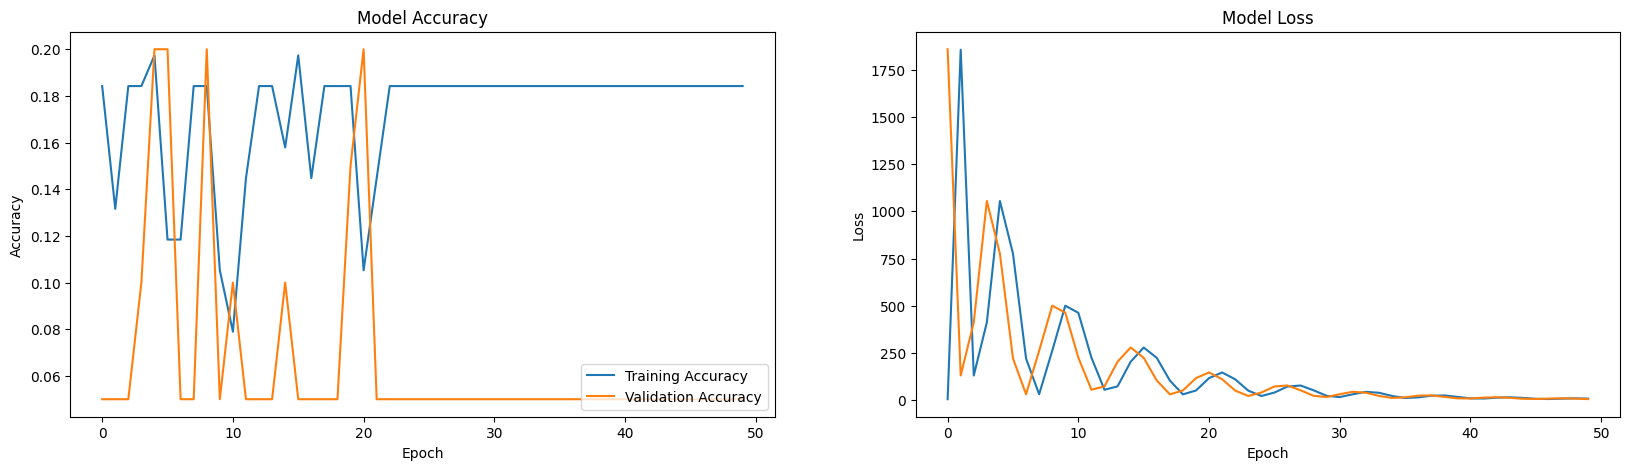

In [15]:

plot_history(history)